In [4]:
from haloflow import data as D

In [17]:
import numpy as np

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.autograd import Function

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
obs = 'mags'
source_sim = 'TNG50'
target_sim = 'TNG100'

In [8]:
# Load data for Sim X (source domain)
Y_source, X_source = D.hf2_centrals(dataset='train', obs=obs, sim=source_sim)
Y_source_test, X_source_test = D.hf2_centrals(dataset='test', obs=obs, sim=source_sim)

# Load data for Sim Y (target domain)
Y_target, X_target = D.hf2_centrals(dataset='train', obs=obs, sim=target_sim)
Y_target_test, X_target_test = D.hf2_centrals(dataset='test', obs=obs, sim=target_sim)

In [14]:
# Combine source and target data for scaling
scaler = StandardScaler()
X_combined = np.vstack([X_source, X_target])
scaler.fit(X_combined)

# Scale the data
X_source = scaler.transform(X_source)
X_target = scaler.transform(X_target)
X_source_test = scaler.transform(X_source_test)
X_target_test = scaler.transform(X_target_test)

# Convert to PyTorch tensors
X_source = torch.tensor(X_source, dtype=torch.float32)
Y_source = torch.tensor(Y_source, dtype=torch.float32)
X_target = torch.tensor(X_target, dtype=torch.float32)
X_target_test = torch.tensor(X_target_test, dtype=torch.float32)
X_source_test = torch.tensor(X_source_test, dtype=torch.float32)
Y_source_test = torch.tensor(Y_source_test, dtype=torch.float32)

In [18]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x
    

class LabelPredictor(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(LabelPredictor, self).__init__()
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

class DomainClassifier(nn.Module):
    def __init__(self, hidden_dim):
        super(DomainClassifier, self).__init__()
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(x))


class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversal(nn.Module):
    def __init__(self, alpha):
        super(GradientReversal, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)

In [21]:
class DANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, alpha):
        super(DANN, self).__init__()
        self.feature_extractor = FeatureExtractor(input_dim, hidden_dim)
        self.label_predictor = LabelPredictor(hidden_dim, num_classes)
        self.domain_classifier = DomainClassifier(hidden_dim)
        self.gradient_reversal = GradientReversal(alpha)

    def forward(self, x, alpha):
        features = self.feature_extractor(x)
        label_pred = self.label_predictor(features)
        domain_pred = self.domain_classifier(self.gradient_reversal(features))
        return label_pred, domain_pred

In [ ]:
import torch.optim as optim

# Initialize model, optimizer, and loss functions
input_dim = X_source.shape[1]  # Number of features
hidden_dim = 64
num_classes = Y_source.shape[1]  # Number of output classes (e.g., stellar and halo mass)
alpha = 2.0  # Gradient reversal hyperparameter

model = DANN(input_dim, hidden_dim, num_classes, alpha)
optimizer = optim.Adam(model.parameters(), lr=0.001)
label_criterion = nn.MSELoss()  # Use MSE for regression (stellar and halo mass)
domain_criterion = nn.BCELoss()  # Use BCE for domain classification

# Training loop
num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_source), batch_size):
        # Get batches
        src_X_batch = X_source[i:i+batch_size]
        src_Y_batch = Y_source[i:i+batch_size]
        tgt_X_batch = X_target[i:i+batch_size]

        # Forward pass
        src_label_pred, src_domain_pred = model(src_X_batch, alpha)
        _, tgt_domain_pred = model(tgt_X_batch, alpha)

        # Compute losses
        label_loss = label_criterion(src_label_pred, src_Y_batch)
        domain_loss = domain_criterion(src_domain_pred, torch.ones(src_X_batch.size(0), 1)) + \
              domain_criterion(tgt_domain_pred, torch.zeros(tgt_X_batch.size(0), 1))

        # Total loss
        total_loss = label_loss + domain_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}")

In [29]:
model.eval()

# Evaluate on source domain test set
with torch.no_grad():
    src_label_pred, _ = model(X_source_test, alpha)
    src_label_loss = label_criterion(src_label_pred, Y_source_test)
    print(f"Source Domain Test Loss: {src_label_loss.item():.4f}")

# Evaluate on target domain test set (if labels are available)
with torch.no_grad():
    tgt_label_pred, _ = model(X_target_test, alpha)
    if Y_target_test is not None:  # If target domain labels are available
        Y_target_test = torch.tensor(Y_target_test, dtype=torch.float32)
        tgt_label_loss = label_criterion(tgt_label_pred, Y_target_test)
        print(f"Target Domain Test Loss: {tgt_label_loss.item():.4f}")

Source Domain Test Loss: 0.0680
Target Domain Test Loss: 0.2517


/tmp/ipykernel_6714/3742210509.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_target_test = torch.tensor(Y_target_test, dtype=torch.float32)


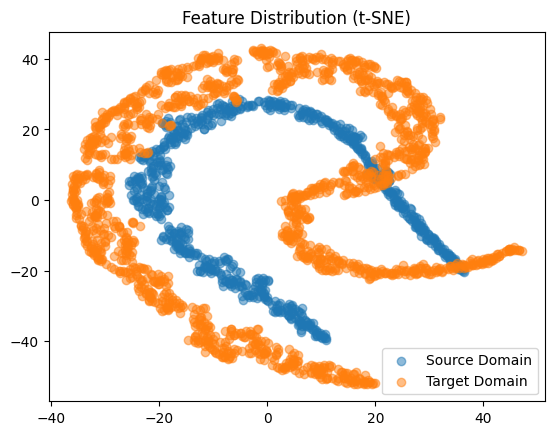

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract features from the feature extractor
model.eval()
with torch.no_grad():
    src_features = model.feature_extractor(X_source_test).cpu().numpy()
    tgt_features = model.feature_extractor(X_target_test).cpu().numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
src_embedded = tsne.fit_transform(src_features)
tgt_embedded = tsne.fit_transform(tgt_features)

# Plot the results
plt.scatter(src_embedded[:, 0], src_embedded[:, 1], label="Source Domain", alpha=0.5)
plt.scatter(tgt_embedded[:, 0], tgt_embedded[:, 1], label="Target Domain", alpha=0.5)
plt.legend()
plt.title("Feature Distribution (t-SNE)")
plt.show()